# Final Exam: Model Deployment in the Cloud

Members: <br>
Espiritu, Missy Anne Jhelzshir G. <br>
Santos, Uneta Tristanneal <br>
Course&Section: CPE 019 - CPE32S9 <br>
Date: May 18, 2024 <br>
Instructor: Engr. Roman Richard <br>

## **IMPORTING MODULES:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time
import cv2
from PIL import Image,ImageOps
import numpy as np
import sys
from matplotlib import pyplot
import pandas as pd
from PIL import Image
from numpy import mean
from numpy import std
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import load_model
from keras.utils import load_img
from keras.utils import img_to_array
from keras.utils import to_categorical

In [3]:
!pip install streamlit
import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image, ImageOps

@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('/content/saved_fashion.h5')
    return model

def import_and_predict(image_data, model):
    size = (64, 64)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    img = np.asarray(image)
    img_reshape = img[np.newaxis, ...]
    prediction = model.predict(img_reshape)
    return prediction

st.write("""
# Fashion Classification"""
)

file = st.file_uploader("Choose a clothing photo from your computer", type=["jpg", "png"])

if file is not None:
    model = load_model()
    image = Image.open(file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    prediction = import_and_predict(image, model)
    # Display prediction results
    st.write("Prediction:", prediction)


2024-05-18 01:25:17.567 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


### **Fashion MNIST Dataset - It contains images of different outfits or those to wear such as shoes, t-shirts, dresses, trousers, boots and many more. It should be able to predict what kind it is when given a test image.**

## **IMPORTING CSV FILE**

In [4]:
train_dataset = pd.read_csv("/content/drive/MyDrive/fashion-mnist_train.csv")
test_dataset = pd.read_csv("/content/drive/MyDrive/fashion-mnist_test.csv")

In [5]:
train_dataset.shape

(47571, 785)

In [6]:
test_dataset.shape

(10000, 785)

In [7]:
train_dataset.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **FORMATTING THE TRAIN AND TEST SETS**

In [8]:
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)


In [9]:
#separate x and y and convert to array

#train dataset
train_datasetX = np.array(train_dataset.iloc[:, 1:])
train_datasetY = np.array(train_dataset.iloc[:, 0])

#test dataset
test_X = np.array(test_dataset.iloc[:, 1:])
test_Y = np.array(test_dataset.iloc[:, 0])

In [10]:
#one hot encoding to the y variables of train and test data
train_datasetY = to_categorical(train_datasetY)
test_Y = to_categorical(test_Y)

In [11]:
batch_size = 64
num_classes = test_Y.shape[1]


In [12]:
#split the train into train and validation (for later purposes)

from sklearn.model_selection import train_test_split

train_X, val_X, train_Y, val_Y = train_test_split(train_datasetX, train_datasetY, test_size=0.2, random_state=13)

In [13]:
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)


(38056, 784)
(9515, 784)
(10000, 784)


In [14]:
def prep_pixels(train_X, val_X, test_X, train_Y, val_Y, test_Y):
  trainX = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
  valX = val_X.reshape(val_X.shape[0], img_rows, img_cols, 1)
  testX = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
  trainY = train_Y
  valY = val_Y
  testY = test_Y
	# convert from integers to floats
  trainX = trainX.astype('float32')
  valX = valX.astype('float32')
  testX = testX.astype('float32')
	# normalize to range 0-1
  trainX = trainX / 255.0
  valX = valX / 255.0
  testX = testX / 255.0

	# return normalized images
  return trainX, valX, testX, trainY, valY, testY

### **We have divided the train, test, and validation for this particular section. There are 10,000 photos for testing and 60,000 images for training in the dataset. Following the splitting, a validation set comprising 12,000 rows is produced. After that, the sets are formatted to make them easier to read. It measures 28 by 28.**

In [15]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.figure(figsize=(16,10))
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')


### **This function plots the loss and accuracy later on after the training is done.**

## **Performing and Saving Augmentation, Utilizing Test Harness**

In [16]:
shift_fraction = 0.005

In [17]:
def run_test_harness(model_x, epochs):
  trainX, valX, testX, trainY, valY, testY = prep_pixels(train_X, val_X, test_X, train_Y, val_Y, test_Y)
  model = model_x
  model.summary()

  #Image Augmentation
  datagen = ImageDataGenerator(width_shift_range=shift_fraction,height_shift_range=shift_fraction,horizontal_flip=True)

  it_train = datagen.flow(trainX, trainY, batch_size=batch_size)
	# prepare iterator
  it_val = datagen.flow(valX, valY, batch_size=batch_size)
  # fit model
  steps = int(trainX.shape[0] / batch_size)
  history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=it_val, verbose=1)
  # evaluate model
  _, acc = model.evaluate(testX, testY, verbose=1)
  print('Accuracy:')
  print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)

**For this part the train, test, and validation data are feed into data generator, which makes it easier for the sets to be preprocessed and then trained later on.**

**The ImageDataGenerator() function is used where the augmentation is done. Featurewise Standardization, ZCA Whitening, Shift Range, and Flips where used.**

**Afterwards a batch of augmented images were saved in local Google drive.**

**The run_test_harness() contains the entire functions needed for training where it only needs to take the model name and it will automatically call the other tasks needed for this activity.**

## **THIRD BASELINE MODEL**

In [18]:
from tensorflow.keras.callbacks import EarlyStopping


In [19]:
# define cnn model
def define_model_3():
	model3 = Sequential()
	model3.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
	model3.add(BatchNormalization())
	model3.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
	model3.add(BatchNormalization())
	model3.add(MaxPooling2D((2, 2)))
	model3.add(Dropout(0.25))

	model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
	model3.add(BatchNormalization())
	model3.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
	model3.add(BatchNormalization())
	model3.add(MaxPooling2D((2, 2)))
	model3.add(Dropout(0.25))

	model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
	model3.add(BatchNormalization())
	model3.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
	model3.add(BatchNormalization())
	model3.add(MaxPooling2D((2, 2)))
	model3.add(Dropout(0.25))

	model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
	model3.add(BatchNormalization())
	model3.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
	model3.add(BatchNormalization())
	model3.add(MaxPooling2D((2, 2)))
	model3.add(Dropout(0.25))



	model3.add(Flatten())
	model3.add(Dropout(0.25))
	model3.add(Dense(512, activation='relu'))
	model3.add(Dropout(0.25))
	model3.add(Dense(128, activation='relu'))
	model3.add(Dropout(0.25))
	model3.add(Dense(10, activation='softmax'))

	# compile model

	model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
	return model3

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [21]:
model3= define_model_3()

### **Finally, a considerably deeper network with three VGG blocks and 512 nodes in the final hidden layer is employed. Each had max norm per block, batch normalization per convolutional layer, and rising dropout rates. Adam was the optimizer, and 100 epochs were utilized. It outperformed the previous two models, as predicted, with 98% accuracy on the dataset and 94% validation. Although there is still some acceptable overfitting, it functioned nicely.**

## **Finalization, saving of model, and testing on new images**

In [22]:
trainX, valX, testX, trainY, valY, testY = prep_pixels(train_X, val_X, test_X, train_Y, val_Y, test_Y)

In [23]:
model3.save('/content/drive/MyDrive/Models/saved_fashion.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape the data to match the model's expected input shape (None, 784)
X_train = X_train.reshape(-1, 28*28).astype('float32') / 255
X_test = X_test.reshape(-1, 28*28).astype('float32') / 255

# Define a simple model
model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(10, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5)

# Evaluate the model
model.evaluate(X_test, y_test)


Epoch 1/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2613 - accuracy: 0.9255
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1173 - accuracy: 0.9646
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0810 - accuracy: 0.9761
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0615 - accuracy: 0.9812
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0764 - accuracy: 0.9769


[0.07639231532812119, 0.9768999814987183]

In [25]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image
def load_image(filename):
  img = Image.open(filename).resize((224, 224))
  plt.imshow(img)
  plt.show()
  img = load_img(filename, target_size=(28, 28))
  img = img_to_array(img)
  img = img[:,:,0]
  img = img.reshape(1,28, 28, 1)
  img = img.astype('float32')
  img = img / 255.0
  return img

def run_example(filename):
  img = load_image(filename)
  model = load_model('/content/drive/MyDrive/Models/saved_fashion.h5')
  result = np.argmax(model.predict(img), axis=1)
  if result == 0:
    print('Tshirt')
  elif result == 1:
    print('Top')
  elif result == 2:
    print('Pullover')
  elif result == 3:
    print('Dress')
  elif result == 4:
    print('Coat')
  elif result == 5:
    print('Sandal')
  elif result == 6:
    print('Shirt')
  elif result == 7:
    print('Snicker')
  elif result == 8:
    print('Bag')
  else:
    print('Ankle Boot')

In [26]:
import streamlit as st
import tensorflow as tf
import cv2
from PIL import Image,ImageOps
import numpy as np

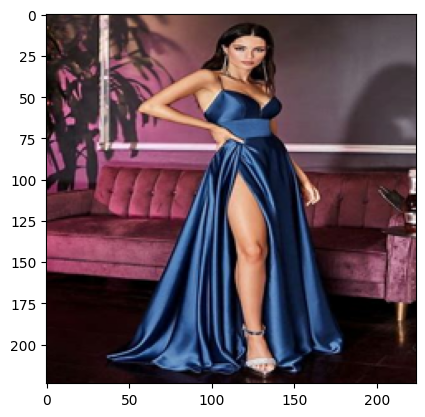

1/1 [==============================] - 0s 257ms/step
Sandal


In [27]:
run_example('/content/kiki_fashion_example.jpg')

In [ ]:
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py





  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.245.186.159:8501

